# Monte Carlo Simulations for _Anomalous Salt Dependence Reveals an Interplay of Attractive and Repulsive Electrostatic Interactions in α-synuclein Fibril Formation_

https://doi.org/10.1017/qrd.2020.7

## Simulation details

Peptides are modelled as flexible chains of harmonically cennected beads ($r_{eq}=7$ Å, $k=3~k_BT/$Å$^2$), each representing an amino acid.
The beads are further subject to nonbonded interactions through a pair potential,
$\beta u(r)=\lambda_Bz_iz_je^{-r/\lambda_D}/r + 4\beta\epsilon_{ij}\left ( (\sigma_{ij}/r)^{12} - (\sigma_{ij}/r)^{6}\right )$ where
$r$ is the amino acid separation;
$z$ are charge valencies;
$\lambda_B=7$ Å the Bjerrum length in water;
$\lambda_D$ is the Debye screening length;
$\epsilon_{ij}$ is the Lennard-Jones (LJ) interaction strength; and
$\sigma_{ij}$ the LJ diameter.

The system consists of a cubic slit-geometry of side-length, $L=500$ Å where 208 c-terminal peptides are anchored to one side ($xy$-plane) via their N-termini. Periodic boundary conditions are applied in the $x$ and $y$ directions and a single, unconstrained $\alpha$-syn chain is added.

Configurational space in the Canonical ensemble ($T$=300 K) is explored using Metropolis Monte Carlo simulations consisting of
- single amino acid translation
- single peptide translation/rotation
- pivot rotations around randomly selected bonds.

Finally (iv), the protonation state of acidic and basic residues are allowed to fluctuate via swap moves, associated with an intrinsic energy cost of $(pH-pK_a)\cdot \ln 10$.
A snapshot of the system is shown below and the peptide model is described in detail elsewhere (Chris Evers Langmuir paper).
All simulations were performed using Faunus v2.2.0.

<img src="figs/snapshot.png" alt="snapshot" width="400"/>

## Analyse peptide-surface potential of mean force

In [7]:
%matplotlib inline
import os
from cycler import cycler
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.interpolate import UnivariateSpline


def RChistogram(file, bins, sel="all"):
    """create histogram from Reaction Coordinate file"""
    d = np.loadtxt(file, usecols=[1]).T  # peptide cm_z as a function of steps
    if sel == "first":
        d = np.array_split(d, 2)[0]
    if sel == "second":
        d = np.array_split(d, 2)[1]

    hist, r = np.histogram(d, bins=bins, density=True)
    vals = (r[:-1] + r[1:]) / 2 + Lz / 2

    return hist, vals


def histogram_to_gofr(r, hist):
    """convert histogram g(r) to PMF by Boltzmann inversion"""
    w = -np.log(hist)
    w = w - w[(r > 280) & (r < 300)].mean()
    gofr = np.exp(-w)
    maxdh = find_nearest(gofr, 1)
    maxd = find_nearest(gofr, 2)
    return gofr


def xremap(x, y, xtarget, smoothing=0.1):
    """use splining to map to target x-range"""
    mask = np.isfinite(y)  # only allow finite values
    x = x[mask]
    y = y[mask]
    spline = UnivariateSpline(x, y)
    spline.set_smoothing_factor(smoothing)
    return spline(xtarget)


def joinRC(xfile, yfile, bins, sel="all"):
    x = np.loadtxt(xfile, usecols=[1])
    y = np.loadtxt(yfile, usecols=[1])
    if sel == "first":
        x = np.array_split(x, 2)[0]
        y = np.array_split(y, 2)[0]
    if sel == "second":
        x = np.array_split(x, 2)[1]
        y = np.array_split(y, 2)[1]

    means, edges, bins = binned_statistic(x, y, "mean", bins)
    return (edges[:-1] + edges[1:]) / 2, means


N = 208  # number of C-terms on surface
Lx = 500  # angstrom
print(f"C-terminal density: {Lx**2/N} angstrom squared per molecule")

default_cycler = cycler(color=["black", "purple", "blue", "cyan", "green", "orange"])

plt.rc("axes", prop_cycle=default_cycler)
plt.show()

C-terminal density: 1201.923076923077 angstrom squared per molecule


20mM/: dr = 1.34 Å
22mM/: dr = 1.29 Å
24mM/: dr = 1.30 Å
30mM/: dr = 1.29 Å
50mM/: dr = 1.27 Å
150mM/: dr = 1.27 Å


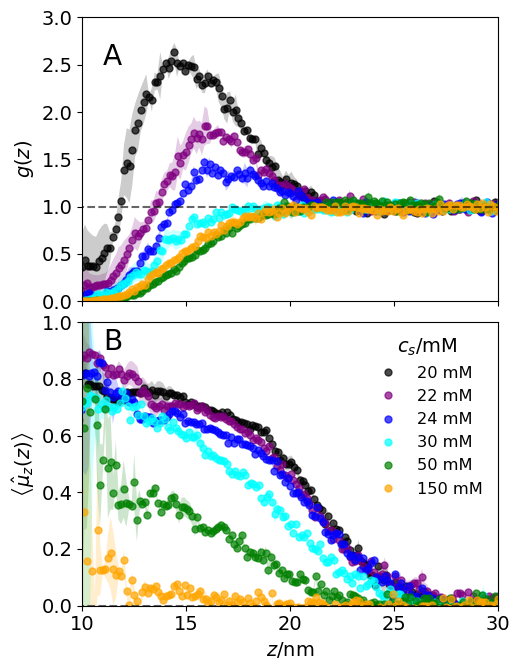

In [11]:
Lz = 500  # length of box in z-direction
concrange = [20, 22, 24, 30, 50, 150]  # salt conc in mM
plt.rcParams.update({"font.size": 14})
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6.5))


def find_nearest(y, y0):
    idx = (np.abs(y - y0)).argmin()
    return idx


def plotGOFR(axis, bins, recalc=False):
    """plots g(r)"""
    for conc in concrange:
        prefix = str(conc) + "mM/"
        gofrfile = prefix + "gofr.dat"
        if not os.path.isfile(gofrfile) or recalc:
            file = prefix + "zdist.dat"

            hist, r = RChistogram(file, bins)
            gofr = histogram_to_gofr(r=r, hist=hist)

            hist1, r1 = RChistogram(file, bins, sel="first")
            gofr1 = histogram_to_gofr(r=r1, hist=hist1)
            gofr1 = xremap(r1, gofr1, r)

            hist2, r2 = RChistogram(file, bins, sel="second")
            gofr2 = histogram_to_gofr(r=r2, hist=hist2)
            gofr2 = xremap(r2, gofr2, r)

            stddev = np.std([gofr1, gofr2], axis=0)

            np.savetxt(gofrfile, [r, gofr, stddev])
        else:
            r, gofr, stddev = np.loadtxt(gofrfile)

        rs = np.linspace(100, 300, 100)

        r = r / 10  # nm
        axis.plot(r, gofr, "o", label=str(conc), alpha=0.7, markersize=5)
        axis.fill_between(r, gofr - stddev, gofr + stddev, alpha=0.2)

    axis.set_ylabel(r"$g(z)$")
    axis.plot([0, 30], [1, 1], "k--", alpha=0.6)


def plotmucorr(axis, bins, recalc=False):
    """plots dipolar correlation as a function of COM"""
    for conc in concrange:
        path = str(conc) + "mM/"
        mufile = path + "mucorr.dat"
        if not os.path.isfile(mufile) or recalc:
            # average over all configurations
            r, mu = joinRC(path + "zdist.dat", path + "muz.dat", bins)
            r, muscalar = joinRC(path + "zdist.dat", path + "mu.dat", bins)

            # average over first half of configs.
            r1, mu1 = joinRC(path + "zdist.dat", path + "muz.dat", bins, sel="first")
            r1, muscalar1 = joinRC(
                path + "zdist.dat", path + "mu.dat", bins, sel="first"
            )
            mu_over_muscalar1 = xremap(r1, mu1 / muscalar1, r)

            # average over second half of configs.
            r2, mu2 = joinRC(path + "zdist.dat", path + "muz.dat", bins, sel="second")
            r2, muscalar2 = joinRC(
                path + "zdist.dat", path + "mu.dat", bins, sel="second"
            )
            mu_over_muscalar2 = xremap(r2, mu2 / muscalar2, r)

            # standard devistion estimate from the two halfs
            stddev = np.std([mu_over_muscalar1, mu_over_muscalar2], axis=0)

            np.savetxt(mufile, [r, mu, muscalar, stddev])
        else:
            r, mu, muscalar, stddev = np.loadtxt(mufile)

        print(f"{path}: dr = {np.diff(r)[0]:.2f} Å")
        r = (r + Lz / 2) / 10
        axis.plot(
            r, -mu / muscalar, "o", markersize=5, alpha=0.7, label=str(conc) + " mM"
        )
        axis.fill_between(
            r, -mu / muscalar - stddev, -mu / muscalar + stddev, alpha=0.2
        )

    axis.set_xlabel(r"$z$/nm")
    axis.set_ylabel(r"$\left \langle \hat\mu_z(z) \right \rangle$")
    # axis.set_ylabel(r'$\langle \mu_z(z) \rangle / \langle |\mu(z)| \rangle$')
    axis.plot([0, 30], [0, 0], "k--", alpha=0.6)
    axis.legend(loc=0, frameon=False, fontsize="small", title=r"$c_s$/mM", ncol=1)


ax1.set_xlim(10, 30)
ax1.set_ylim(0, 3)

ax2.set_xlim(10, 30)
ax2.set_ylim(0, 1)

ax1.text(11, 2.5, "A", fontsize="x-large")
ax2.text(11, 0.9, "B", fontsize="x-large")

bins = 300
recalc = False
plotGOFR(ax1, bins, recalc)
plotmucorr(ax2, bins, recalc)

plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.1)
plt.savefig("figs/gofr.png", bbox_inches="tight", dpi=300)
plt.savefig("figs/gofr.pdf", bbox_inches="tight")
plt.show()

### End-2-end distance probability

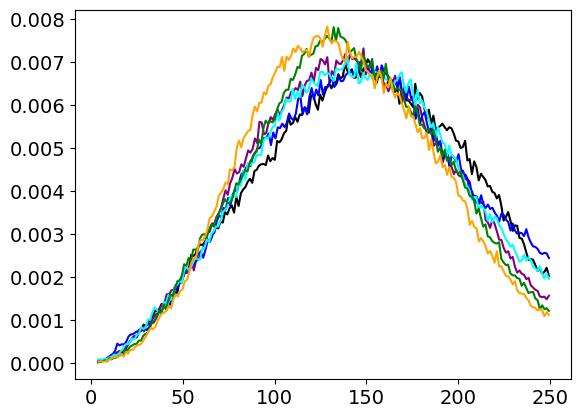

In [3]:
for conc in concrange:
    path = str(conc) + "mM/"
    e2e = np.loadtxt(path + "e2e.dat", usecols=[1])
    P, bins = np.histogram(e2e, bins=200, density=True)
    e2e = (bins[:-1] + bins[1:]) / 2
    plt.plot(e2e, P)